# Prague Real Estate Analysis

Analysis of apartment prices near Prague metro stations. Data scraped from sreality.cz (2898 listings).

**Goal:** Find which metro stations/lines have highest prices and build a simple price prediction model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load processed data
# Try pre-processed data first, then freshly processed data
import os

if os.path.exists("data/data_estate_processed_06012026.csv"):
    df = pd.read_csv("data/data_estate_processed_06012026.csv")
    print("Using pre-processed data (Jan 2026)")
elif os.path.exists("data/data_estate_processed.csv"):
    df = pd.read_csv("data/data_estate_processed.csv")
    print("Using freshly processed data")
else:
    raise FileNotFoundError("No processed data found. Run data_preprocessing.py first.")

print(f"Loaded {len(df)} apartments")
print(f"Columns: {len(df.columns)}")
df.head()

Using pre-processed data (Jan 2026)
Loaded 2898 apartments
Columns: 115


,discount_show,price,latitude,longitude,area_usable,has_elevator,has_terrace,floor_number,500m_atm_distance,500m_bus_public_transport_distance,...,nearest_station_Stodůlky,nearest_station_Strašnická,nearest_station_Střížkov,nearest_station_Vltavská,nearest_station_Vysočanská,nearest_station_Vyšehrad,nearest_station_Zličín,nearest_station_Černý Most,nearest_station_Českomoravská,nearest_station_Želivského
0,False,22960500.0,50.016342,14.403686,116,0,0,15,0,1,...,False,False,False,False,False,False,False,False,False,False
1,False,13950000.0,50.077742,14.407670,67,0,0,3,1,1,...,False,False,False,False,False,False,False,False,False,False
2,False,9490000.0,50.070650,14.449091,43,1,11,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,False,7645000.0,50.141229,14.575347,63,0,1,2,1,1,...,False,False,False,False,False,False,False,True,False,False
4,False,11599000.0,50.021361,14.466308,91,0,14,5,1,1,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# Basic data overview
print("Data shape:", df.shape)
print("\nColumn types:")
print(df.dtypes.value_counts())
print("\nBasic statistics for price:")
print(df['price'].describe())

Data shape: (2898, 115)

Column types:
bool       89
int64      20
float64     6
Name: count, dtype: int64

Basic statistics for price:
count    2.898000e+03
mean     1.235407e+07
std      7.812680e+06
min      0.000000e+00
25%      8.130880e+06
50%      1.040442e+07
75%      1.456000e+07
max      8.700000e+07
Name: price, dtype: float64


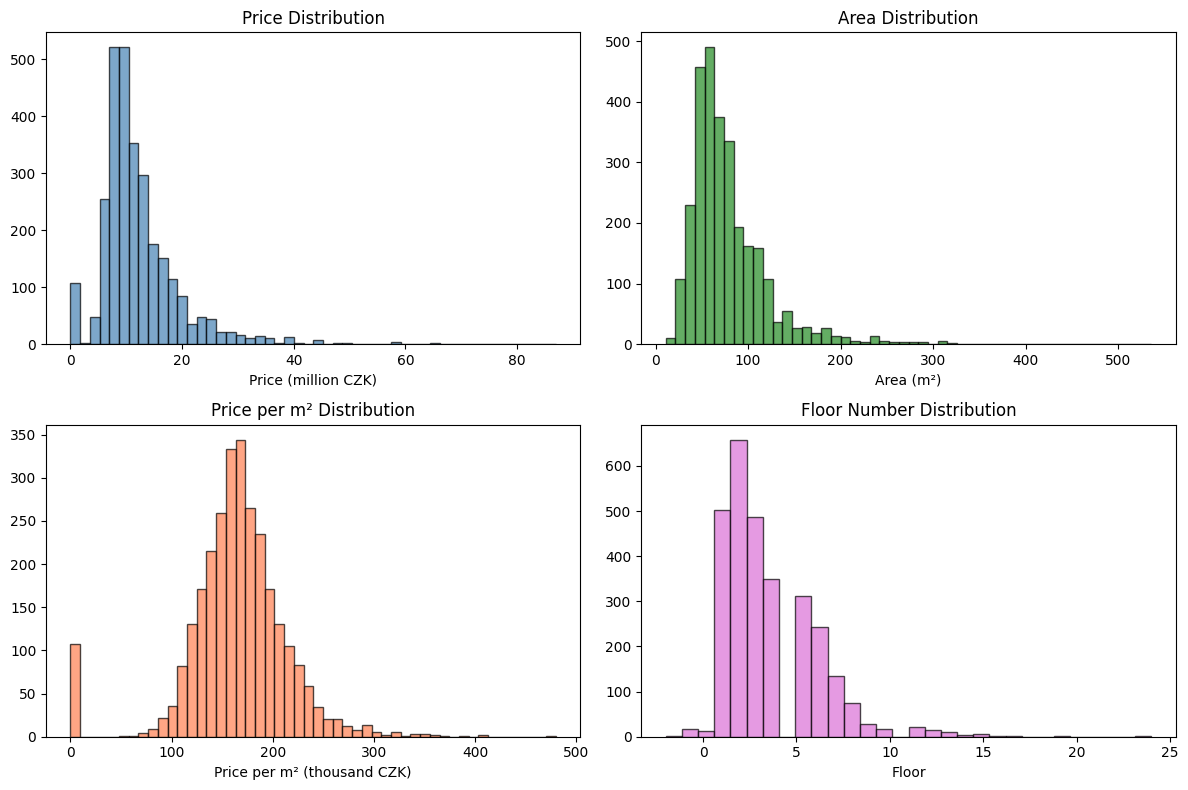

In [4]:
# Distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Price
axes[0,0].hist(df['price'] / 1e6, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Price (million CZK)')
axes[0,0].set_title('Price Distribution')

# Area
axes[0,1].hist(df['area_usable'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0,1].set_xlabel('Area (m²)')
axes[0,1].set_title('Area Distribution')

# Price per m2
df['price_per_m2'] = df['price'] / df['area_usable']
axes[1,0].hist(df['price_per_m2'] / 1000, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1,0].set_xlabel('Price per m² (thousand CZK)')
axes[1,0].set_title('Price per m² Distribution')

# Floor number
axes[1,1].hist(df['floor_number'].dropna(), bins=30, color='orchid', edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Floor')
axes[1,1].set_title('Floor Number Distribution')

plt.tight_layout()
plt.show()

Most prices are between 5-15 million CZK with a few expensive outliers. Typical apartment size is 50-100 m². Price per m² is mostly around 150-200k CZK. Most apartments are on lower floors (1-5), which makes sense for Prague buildings.

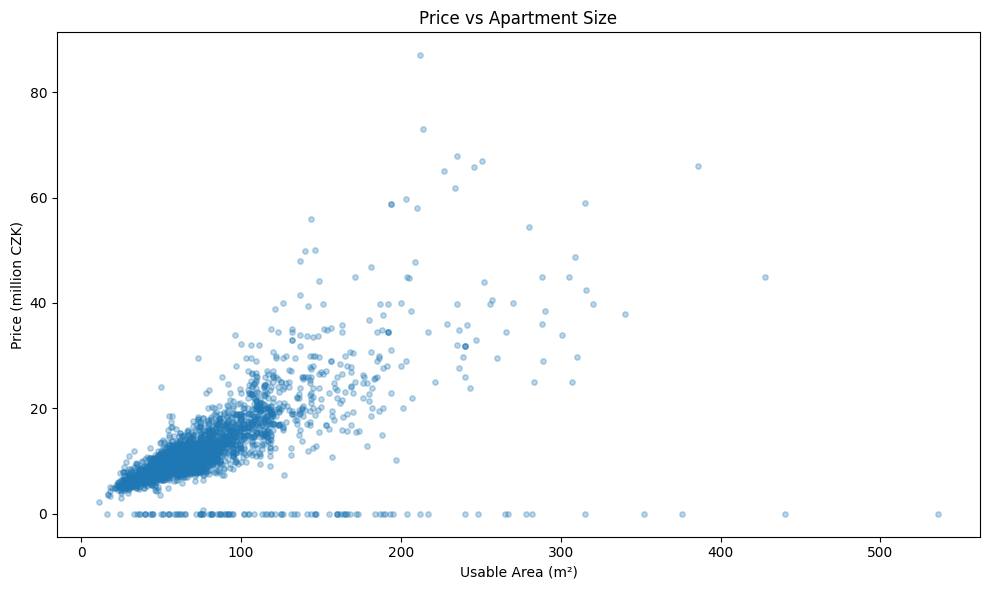

In [5]:
# Price vs Area relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['area_usable'], df['price'] / 1e6, alpha=0.3, s=15)
plt.xlabel('Usable Area (m²)')
plt.ylabel('Price (million CZK)')
plt.title('Price vs Apartment Size')
plt.tight_layout()
plt.show()

Bigger apartments cost more, as expected. There are some listings with price = 0 or very low values. These are probably errors or placeholder values that we need to filter out before modeling.

## Metro Station Analysis

In [6]:
# Get nearest station from one-hot encoded columns
station_cols = [col for col in df.columns if col.startswith('nearest_station_')]
print(f"Found {len(station_cols)} station columns")

# Create nearest_station column from one-hot encoding
def get_nearest_station(row):
    for col in station_cols:
        if row[col] is True or row[col] == 1:
            return col.replace('nearest_station_', '')
    return None

df['nearest_station'] = df.apply(get_nearest_station, axis=1)
print(f"\nStations found: {df['nearest_station'].nunique()}")

Found 57 station columns

Stations found: 57


In [7]:
# Load metro stations data to get line info
try:
    metro = pd.read_csv("data/metro_stations.csv")
    print("Metro stations:")
except FileNotFoundError:
    print("Error: metro_stations.csv not found")
print("Metro stations:")
print(metro.head(15))

# Create station to line mapping
station_to_line = dict(zip(metro['name'], metro['line']))

# Add metro line to dataframe
df['metro_line'] = df['nearest_station'].map(station_to_line)
print("\nApartments by metro line:")
print(df['metro_line'].value_counts())

Metro stations:
Metro stations:
   line                name        lat        lng
0     A     Nemocnice Motol  50.075175  14.340845
1     A             Petřiny  50.087053  14.344830
2     A  Nádraží Veleslavín  50.095372  14.346919
3     A          Bořislavka  50.098517  14.364090
4     A            Dejvická  50.100471  14.393175
5     A          Hradčanská  50.097511  14.404480
6     A        Malostranská  50.090857  14.409348
7     A        Staroměstská  50.088598  14.416234
8     A              Můstek  50.084084  14.423664
9     A              Muzeum  50.079608  14.429976
10    A        Náměstí Míru  50.075164  14.437724
11    A   Jiřího z Poděbrad  50.077610  14.449160
12    A               Flora  50.078011  14.461258
13    A          Želivského  50.078364  14.474210
14    A          Strašnická  50.072783  14.491222

Apartments by metro line:
metro_line
B    1095
C     997
A     682
Name: count, dtype: int64


In [8]:
# Calculate price per m2
df['price_per_m2'] = df['price'] / df['area_usable']

# Remove outliers (very extreme prices)
def remove_outliers(df, column, lower_q=0.02, upper_q=0.98):
    """Remove outliers based on quantile thresholds."""
    q_low = df[column].quantile(lower_q)
    q_high = df[column].quantile(upper_q)
    return df[(df[column] >= q_low) & (df[column] <= q_high)].copy()
    
df_clean = remove_outliers(df, 'price_per_m2')

print(f"Original: {len(df)} rows")
print(f"After removing outliers: {len(df_clean)} rows")
print(f"\nPrice per m2 range: {df_clean['price_per_m2'].min():.0f} - {df_clean['price_per_m2'].max():.0f} CZK")

Original: 2898 rows
After removing outliers: 2840 rows

Price per m2 range: 0 - 271189 CZK


## 1. Prices by Station

In [9]:
# Average price per m2 by station
station_prices = df_clean.groupby('nearest_station').agg({
    'price_per_m2': 'mean',
    'price': 'mean',
    'nearest_station': 'count'
}).rename(columns={'nearest_station': 'count'})

station_prices = station_prices.sort_values('price_per_m2', ascending=False)

print("TOP 10 MOST EXPENSIVE STATIONS (by price per m2):")
print(station_prices.head(10).round(0))
print("\n" + "="*50)
print("\nTOP 10 CHEAPEST STATIONS (by price per m2):")
print(station_prices.tail(10).round(0))

TOP 10 MOST EXPENSIVE STATIONS (by price per m2):
                    price_per_m2       price  count
nearest_station                                    
Malostranská            198158.0  25296125.0      8
Muzeum                  192812.0  14307264.0     14
Náměstí Míru            191593.0  15155906.0     39
Invalidovna             191333.0  13017626.0     90
Jiřího z Poděbrad       186744.0  13943870.0     67
Florenc                 180648.0  14435735.0     27
Smíchovské nádraží      178381.0  14302558.0     66
I. P. Pavlova           176966.0  12080723.0     23
Křižíkova               176957.0  14635246.0     32
Radlická                174345.0  13025088.0     60


TOP 10 CHEAPEST STATIONS (by price per m2):
                 price_per_m2       price  count
nearest_station                                 
Ládví                144699.0  11469175.0     26
Lužiny               144311.0  11462086.0     69
Petřiny              142503.0  10695386.0     38
Rajská zahrada       141889.0   874

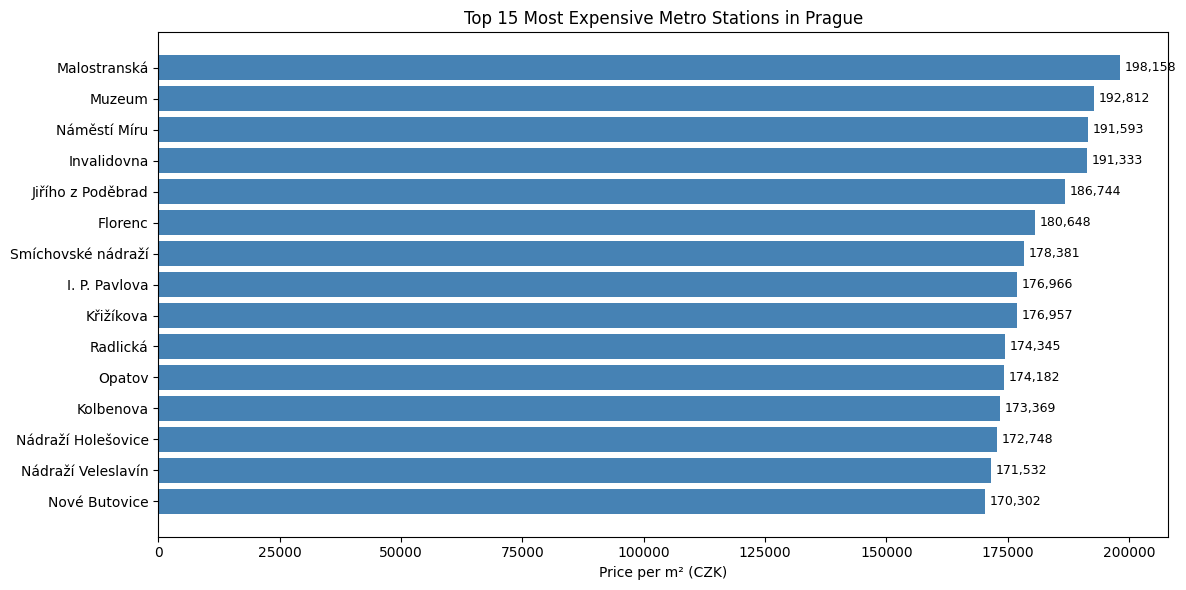

In [10]:
# Visualization: Top 15 most expensive stations
fig, ax = plt.subplots(figsize=(12, 6))

top_15 = station_prices.head(15)
bars = ax.barh(top_15.index, top_15['price_per_m2'], color='steelblue')
ax.set_xlabel('Price per m² (CZK)')
ax.set_title('Top 15 Most Expensive Metro Stations in Prague')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, top_15['price_per_m2']):
    ax.text(val + 1000, bar.get_y() + bar.get_height()/2, 
            f'{val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 2. Metro Line Comparison (A vs B vs C)

In [11]:
line_prices = df_clean.groupby('metro_line').agg({
    'price_per_m2': ['mean', 'median', 'std'],
    'price': ['mean', 'count']
}).round(0)

line_prices.columns = ['avg_price_m2', 'median_price_m2', 'std_price_m2', 'avg_price', 'count']
print("AVERAGE PRICES BY METRO LINE:")
print(line_prices)

# Calculate how much more expensive Line A is compared to C
if 'A' in line_prices.index and 'C' in line_prices.index:
    diff = (line_prices.loc['A', 'avg_price_m2'] / line_prices.loc['C', 'avg_price_m2'] - 1) * 100
    print(f"\nLine A is {diff:.1f}% more expensive than Line C (per m²)")

AVERAGE PRICES BY METRO LINE:
            avg_price_m2  median_price_m2  std_price_m2   avg_price  count
metro_line                                                                
A               162805.0         165670.0       51148.0  13049556.0    654
B               162627.0         165789.0       47433.0  12117721.0   1083
C               158024.0         162488.0       40802.0  10806620.0    987

Line A is 3.0% more expensive than Line C (per m²)


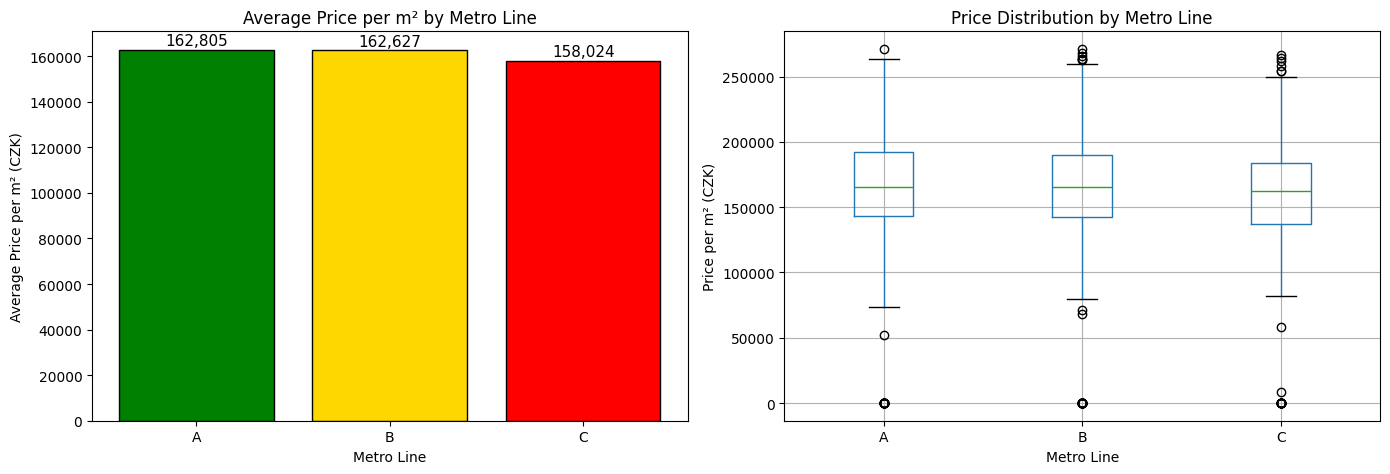

In [12]:
# Visualization: Price comparison by metro line
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of average prices
colors = {'A': 'green', 'B': 'gold', 'C': 'red'}
line_order = ['A', 'B', 'C']
avg_prices = [line_prices.loc[line, 'avg_price_m2'] for line in line_order if line in line_prices.index]
bar_colors = [colors[line] for line in line_order if line in line_prices.index]

axes[0].bar(line_order, avg_prices, color=bar_colors, edgecolor='black')
axes[0].set_ylabel('Average Price per m² (CZK)')
axes[0].set_xlabel('Metro Line')
axes[0].set_title('Average Price per m² by Metro Line')
for i, v in enumerate(avg_prices):
    axes[0].text(i, v + 2000, f'{v:,.0f}', ha='center', fontsize=11)

# Box plot of price distribution
df_plot = df_clean[df_clean['metro_line'].isin(['A', 'B', 'C'])]
df_plot.boxplot(column='price_per_m2', by='metro_line', ax=axes[1])
axes[1].set_title('Price Distribution by Metro Line')
axes[1].set_xlabel('Metro Line')
axes[1].set_ylabel('Price per m² (CZK)')
plt.suptitle('')

plt.tight_layout()
plt.show()

The difference between lines is smaller than I expected.  Line A is only about 3% more expensive than Line C. All three lines have similar median prices around 162-166k CZK/m².

In [13]:
# Price by distance to nearest metro
df_clean['min_metro_dist'] = df_clean[['metro_dist_A', 'metro_dist_B', 'metro_dist_C']].min(axis=1)

# Group by distance
bins = [0, 500, 1000, 1500, 3000]
labels = ['<500m', '500-1000m', '1000-1500m', '>1500m']
df_clean['distance_group'] = pd.cut(df_clean['min_metro_dist'], bins=bins, labels=labels)

price_by_dist = df_clean.groupby('distance_group')['price_per_m2'].mean().round(0)
print("Average price per m² by distance to metro:")
print(price_by_dist)

Average price per m² by distance to metro:
distance_group
<500m         171628.0
500-1000m     166413.0
1000-1500m    159039.0
>1500m        150886.0
Name: price_per_m2, dtype: float64


/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_27377/2853704034.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_dist = df_clean.groupby('distance_group')['price_per_m2'].mean().round(0)


## 3. Station Ranking

In [14]:
# Add line info to station prices
station_prices['line'] = station_prices.index.map(station_to_line)

# Create ranking
station_prices['rank'] = range(1, len(station_prices) + 1)

print("FULL STATION RANKING BY PRICE PER M²:")
print("="*60)
ranking = station_prices[['rank', 'line', 'price_per_m2', 'count']].copy()
ranking.columns = ['Rank', 'Line', 'Avg Price/m²', 'Apartments']
print(ranking.to_string())

FULL STATION RANKING BY PRICE PER M²:
                    Rank Line   Avg Price/m²  Apartments
nearest_station                                         
Malostranská           1    A  198158.066425           8
Muzeum                 2    C  192811.741438          14
Náměstí Míru           3    A  191592.506768          39
Invalidovna            4    B  191333.499186          90
Jiřího z Poděbrad      5    A  186744.007021          67
Florenc                6    C  180647.843583          27
Smíchovské nádraží     7    B  178380.551721          66
I. P. Pavlova          8    C  176966.489537          23
Křižíkova              9    B  176956.715305          32
Radlická              10    B  174345.475972          60
Opatov                11    C  174182.018745          46
Kolbenova             12    B  173369.391559          67
Nádraží Holešovice    13    C  172747.632096          50
Nádraží Veleslavín    14    A  171532.007444          15
Nové Butovice         15    B  170301.835198      

## Correlation Analysis

In [15]:
# Select numeric columns for correlation
numeric_cols = ['price', 'area_usable', 'floor_number', 'has_elevator', 
                'has_terrace', 'metro_dist_A', 'metro_dist_B', 'metro_dist_C']
numeric_cols = [c for c in numeric_cols if c in df.columns]

# Calculate correlations with price
correlations = df[numeric_cols].corr()['price'].drop('price').sort_values(ascending=False)

print("CORRELATION WITH PRICE:")
print("="*40)
for col, corr in correlations.items():
    print(f"{col:25s}: {corr:+.3f}")

CORRELATION WITH PRICE:
area_usable              : +0.658
has_elevator             : +0.130
floor_number             : +0.125
has_terrace              : +0.070
metro_dist_C             : -0.097
metro_dist_B             : -0.153
metro_dist_A             : -0.189


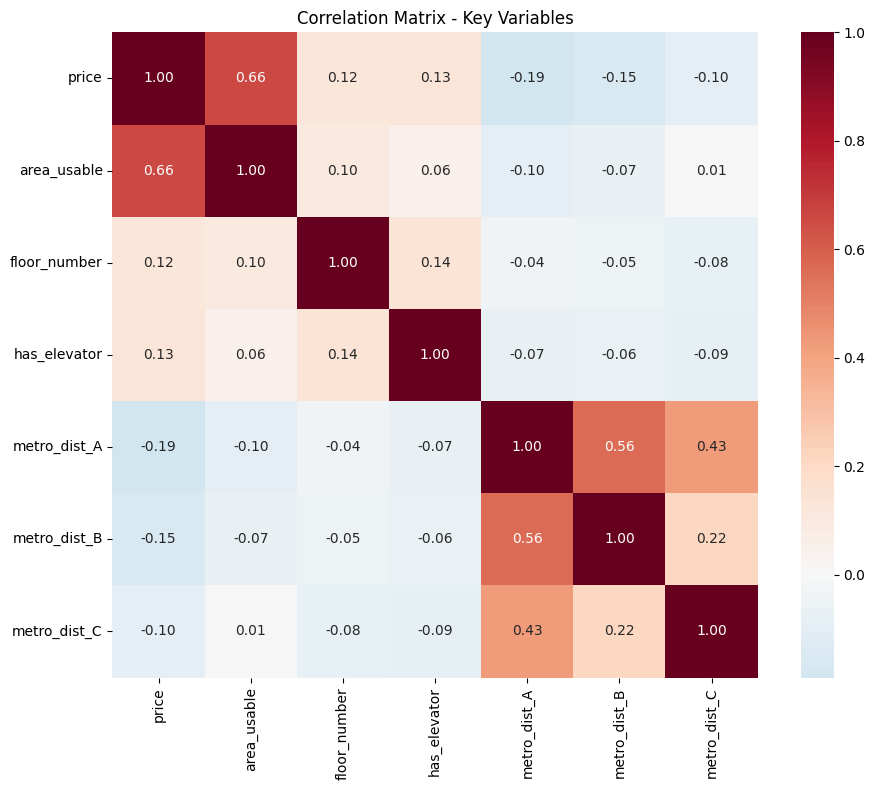

In [16]:
# Correlation heatmap for key variables
fig, ax = plt.subplots(figsize=(10, 8))

# Select key numeric columns
key_cols = ['price', 'area_usable', 'floor_number', 'has_elevator', 
            'metro_dist_A', 'metro_dist_B', 'metro_dist_C']
key_cols = [c for c in key_cols if c in df.columns]

corr_matrix = df[key_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', ax=ax, square=True)
ax.set_title('Correlation Matrix - Key Variables')
plt.tight_layout()
plt.show()

Area has the strongest correlation with price (0.66), which makes sense. Other features like elevator and floor number have weak correlations.

## Price Prediction Model (Linear Regression)

In [17]:
# Convert boolean columns to int for regression
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Remove invalid prices (some listings have 0 or placeholder values)
df_model = df[df['price'] > 100000].copy()

if 'price_per_m2' in df_model.columns:
    df_model = df_model.drop(columns=['price_per_m2'])

# Keep only numeric columns
df_model = df_model.select_dtypes(include=[np.number])
df_model = df_model.dropna()

print(f"After cleaning: {len(df_model)} samples, {df_model.shape[1]} columns")


After cleaning: 2792 samples, 115 columns


In [18]:
# Feature Selection

# Calculate correlation of each feature with price
correlations = df_model.corr()['price'].drop('price').abs().sort_values(ascending=False)

print("Top 15 features by correlation with price:")
print(correlations.head(15))

# Select features with correlation > 0.05 (removing weak predictors)
selected_features = correlations[correlations > 0.04].index.tolist()
print(f"\nSelected {len(selected_features)} features (correlation > 0.05)")

Top 15 features by correlation with price:
area_usable                     0.839641
layout_5kk                      0.374651
layout_4kk                      0.341060
layout_2kk                      0.293469
nearest_station_Staroměstská    0.274435
layout_1kk                      0.271332
district_praha_1                0.268811
layout_6_plus                   0.247072
metro_dist_A                    0.221467
building_type_panel             0.196797
1000m_dist_A                    0.190425
metro_dist_B                    0.180843
1000m_dist_B                    0.180166
layout_atypical                 0.174085
500m_metro_distance             0.159863
Name: price, dtype: float64

Selected 64 features (correlation > 0.05)


In [19]:
# Split features and target using selected features
X = df_model[selected_features]
y = df_model['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Features used: {len(selected_features)}")

Training set: 2233 samples
Test set: 559 samples
Features used: 64


In [20]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("MODEL RESULTS:")
print("="*40)
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score:  {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:,.0f} CZK")

MODEL RESULTS:
Train R² Score: 0.8240
Test R² Score:  0.7851
Test RMSE: 3,694,873 CZK


R² of 0.78 means the model explains about 78% of price variance, which is decent for real estate data. The RMSE of ~3.7 million CZK shows there's still significant prediction error, probably because location and apartment condition matter a lot but are hard to capture.

In [21]:
# Feature importance (model coefficients)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coef', ascending=False)

print("TOP 15 MOST IMPORTANT FEATURES:")
print("="*50)
print(coef_df.head(15).to_string(index=False))

TOP 15 MOST IMPORTANT FEATURES:
                          Feature   Coefficient     Abs_Coef
     nearest_station_Staroměstská  1.459947e+07 1.459947e+07
                         latitude -7.059686e+06 7.059686e+06
     nearest_station_Malostranská  5.080976e+06 5.080976e+06
                       layout_5kk  4.279517e+06 4.279517e+06
                       layout_4kk  3.281103e+06 3.281103e+06
                    layout_6_plus  3.181903e+06 3.181903e+06
                        longitude -2.957362e+06 2.957362e+06
nearest_station_Náměstí Republiky  2.800749e+06 2.800749e+06
           nearest_station_Můstek  2.314501e+06 2.314501e+06
    nearest_station_Národní třída  2.185564e+06 2.185564e+06
                 district_praha_6  1.551376e+06 1.551376e+06
           nearest_station_Muzeum  1.435391e+06 1.435391e+06
                        layout_51 -1.416673e+06 1.416673e+06
                 district_praha_7  1.404138e+06 1.404138e+06
                       status_new  1.331759e+06 1.331

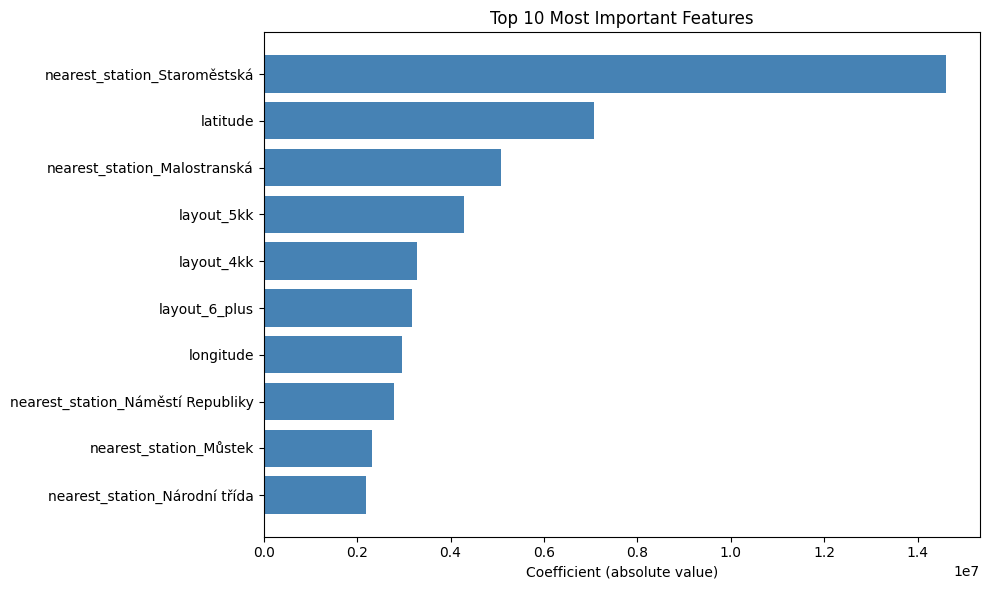

In [22]:
top_features = coef_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Abs_Coef'], color='steelblue')
plt.xlabel('Coefficient (absolute value)')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

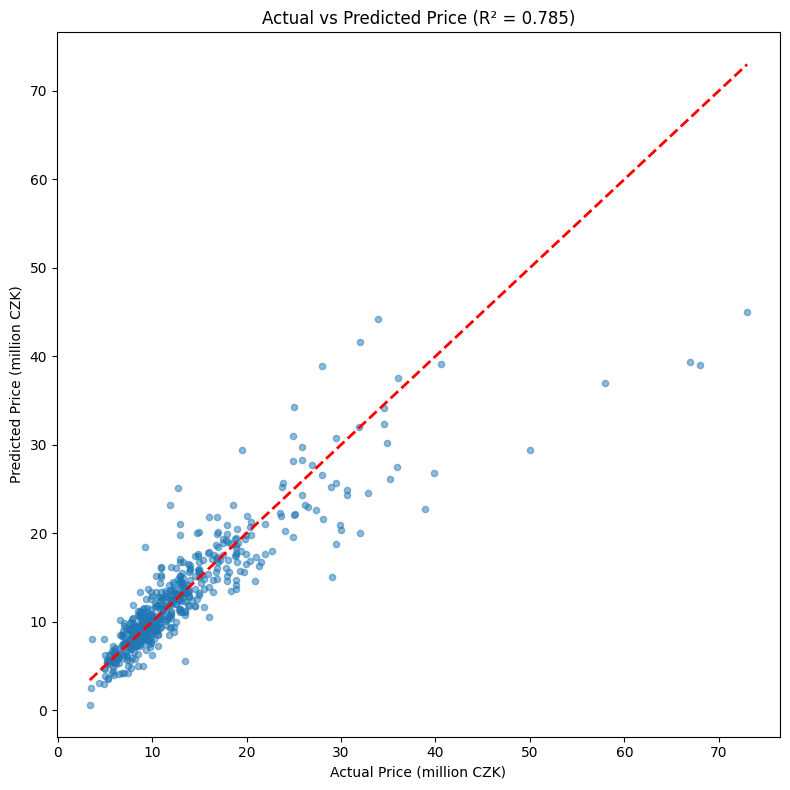

In [23]:
# Actual vs Predicted plot
fig, ax = plt.subplots(figsize=(8, 8))

# Convert to millions for readability
actual_millions = y_test / 1e6
pred_millions = y_pred_test / 1e6

ax.scatter(actual_millions, pred_millions, alpha=0.5, s=20)
ax.plot([actual_millions.min(), actual_millions.max()], 
        [actual_millions.min(), actual_millions.max()], 'r--', lw=2)
ax.set_xlabel('Actual Price (million CZK)')
ax.set_ylabel('Predicted Price (million CZK)')
ax.set_title(f'Actual vs Predicted Price (R² = {test_r2:.3f})')
plt.tight_layout()
plt.show()

Model works well for most apartments but underestimates expensive ones.

## Summary

In [24]:
print("summary")
print(f"Dataset: {len(df)} apartments in Prague")
print(f"Features used: {len(X.columns)}")
print("Model Performance:")
print(f"R² Score (test): {test_r2:.3f}")
print(f"RMSE (test): {test_rmse:,.0f} CZK")

summary
Dataset: 2898 apartments in Prague
Features used: 64
Model Performance:
R² Score (test): 0.785
RMSE (test): 3,694,873 CZK


## Conclusion

The model achieves R² = 0.78, which means it can explain most of the price variation but not everything. Real estate prices depend on many factors that are hard to measure (apartment condition, view, renovation quality, etc.).

**Main findings:**
- Most expensive stations are in the center: Malostranská (198k/m²), Muzeum (193k/m²), Náměstí Míru (192k/m²)
- Cheapest stations: Hlavní nádraží (123k/m²), Černý Most (132k/m²), Letňany (137k/m²)
- Metro line matters less than I expected - only ~3% difference between Line A and C
- Apartment area is the strongest predictor of price (correlation 0.66)

The RMSE of 3.7 million CZK is quite high, which is reasonable but not perfect